In [1]:
# Check for a GPU
import tensorflow as tf
print(tf.test.gpu_device_name())

/gpu:0


In [16]:
%%bash
pwd

/home/ubuntu/Soyoung_Udacity_ND_DeepLearning/5.Generative_Adversarial_Networks/3_face_generation


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

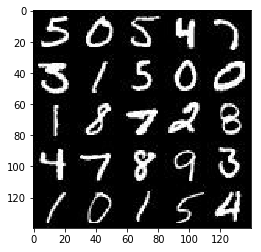

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

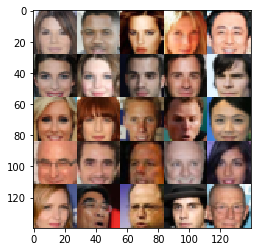

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32, name='learning_rate')
  

    return  inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
#https://discussions.udacity.com/t/discriminator-variable-scope-reuse/662468

stride = 5
padding = 2
img_filter_size = 64
h2_img_filter_size = img_filter_size*2
h3_img_filter_size = img_filter_size*4

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse) :  
        
        alpha=0.01 #if this is not within this variable_scope, can not pass test: assert mock_variable_scope.call_args == mock.call('discriminator', reuse=True)
        #tf.variable_scope called with wrong arguments in Discriminator Inference(reuse=True)
        
        # Hidden layer #1: Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, img_filter_size, stride, padding, 'same')
        relu1 = tf.maximum(alpha * h1, h1)
        # 14x14x64
        
        # Hidden layer #2: 
        h2 = tf.layers.conv2d(relu1, h2_img_filter_size, stride, padding, 'same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Hidden layer #3: 
        h3 = tf.layers.conv2d(relu2, h3_img_filter_size, stride, padding, 'same')
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*h3_img_filter_size))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim,  is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Using the reverse process of the discriminator
        alpha=0.01,
    
        h1 = tf.layers.dense(z, 2*2*h3_img_filter_size)
        h1 = tf.reshape(h1, (-1, 2, 2, h3_img_filter_size))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, h2_img_filter_size, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, img_filter_size, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # discriminator optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25        
    print_every = 10
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1 # next batch
                batch_images *= 2.0 # the image is increasing by double for each layer
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                # performing d_opt with the feed_dict knowledge
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                # performing g_opt with the feed_dict knowledge
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                # Check if is it time to print the Loss or just keep going (skip the print)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator output based on show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5734... Generator Loss: 0.0291
Epoch 1/2... Discriminator Loss: 2.4542... Generator Loss: 10.4210
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 4.0028
Epoch 1/2... Discriminator Loss: 0.4799... Generator Loss: 2.2913
Epoch 1/2... Discriminator Loss: 5.3107... Generator Loss: 0.0132
Epoch 1/2... Discriminator Loss: 0.2338... Generator Loss: 4.0836
Epoch 1/2... Discriminator Loss: 0.2143... Generator Loss: 2.2431
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 1.7818
Epoch 1/2... Discriminator Loss: 0.2713... Generator Loss: 1.7553


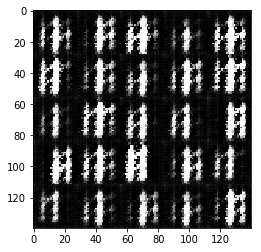

Epoch 1/2... Discriminator Loss: 0.2384... Generator Loss: 4.7258
Epoch 1/2... Discriminator Loss: 0.3097... Generator Loss: 2.4127
Epoch 1/2... Discriminator Loss: 0.3040... Generator Loss: 12.0120
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 3.9883
Epoch 1/2... Discriminator Loss: 0.1729... Generator Loss: 2.9154
Epoch 1/2... Discriminator Loss: 0.2861... Generator Loss: 2.1389
Epoch 1/2... Discriminator Loss: 0.2437... Generator Loss: 2.6743
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 0.1525... Generator Loss: 3.6373


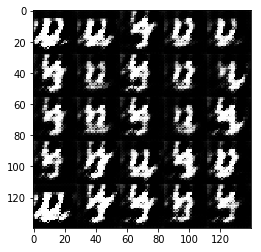

Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.4387
Epoch 1/2... Discriminator Loss: 0.1490... Generator Loss: 4.2300
Epoch 1/2... Discriminator Loss: 0.1960... Generator Loss: 4.9858
Epoch 1/2... Discriminator Loss: 0.0959... Generator Loss: 3.5396
Epoch 1/2... Discriminator Loss: 0.1294... Generator Loss: 3.2869
Epoch 1/2... Discriminator Loss: 0.2485... Generator Loss: 8.1356
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.2607
Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 3.5469
Epoch 1/2... Discriminator Loss: 0.4461... Generator Loss: 1.5968
Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 2.7060


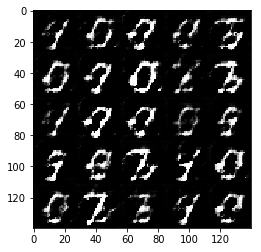

Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.9140
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 2.7954
Epoch 1/2... Discriminator Loss: 0.3535... Generator Loss: 2.8081
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 1.7829
Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 5.2577
Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 1.7412
Epoch 1/2... Discriminator Loss: 0.3496... Generator Loss: 3.1461


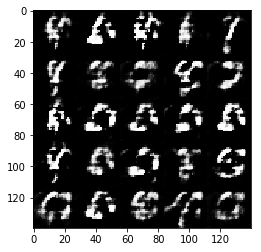

Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 5.5947
Epoch 1/2... Discriminator Loss: 1.8176... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 0.5872... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 2.2581
Epoch 1/2... Discriminator Loss: 0.5019... Generator Loss: 5.3075
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.2838
Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 2.1388
Epoch 1/2... Discriminator Loss: 0.2107... Generator Loss: 2.4870


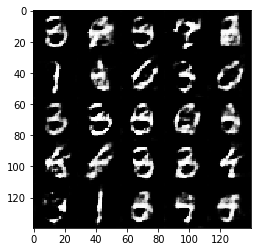

Epoch 1/2... Discriminator Loss: 0.3108... Generator Loss: 3.3085
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 1.3321
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 3.1797
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 6.2748
Epoch 1/2... Discriminator Loss: 0.3956... Generator Loss: 2.9806
Epoch 1/2... Discriminator Loss: 2.2026... Generator Loss: 0.2316
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 2.0135
Epoch 1/2... Discriminator Loss: 0.5211... Generator Loss: 2.8190
Epoch 1/2... Discriminator Loss: 0.6801... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 1.5957


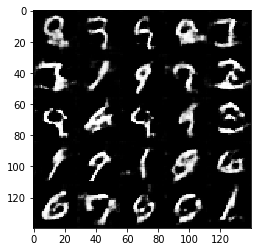

Epoch 1/2... Discriminator Loss: 0.4913... Generator Loss: 1.6553
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.3267
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 1.7347
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 2.1236
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 2.1890
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.4786


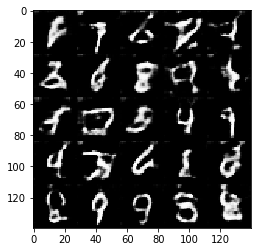

Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 0.5955... Generator Loss: 1.4633
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.7687... Generator Loss: 2.8060
Epoch 1/2... Discriminator Loss: 0.7598... Generator Loss: 2.4023
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 2.9827
Epoch 1/2... Discriminator Loss: 0.5283... Generator Loss: 2.0498
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 0.5581... Generator Loss: 3.0365
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 1.2046


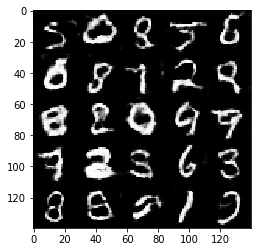

Epoch 1/2... Discriminator Loss: 1.6422... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.6120... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 1.4764
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.5666
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.5903
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.6055... Generator Loss: 0.3678
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.8016


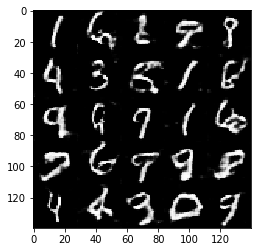

Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 2.1339
Epoch 2/2... Discriminator Loss: 1.7674... Generator Loss: 3.4970
Epoch 2/2... Discriminator Loss: 1.7112... Generator Loss: 0.2850
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.7890
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.4258


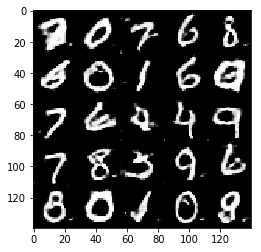

Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 2.7278
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.5033
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 2.2836... Generator Loss: 0.1703
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 1.2413
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 2.1498... Generator Loss: 3.9699
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.7057


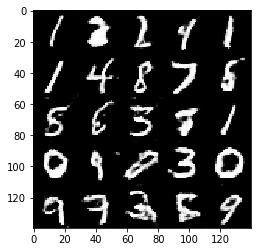

Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 2.5095
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 3.3039
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.3948
Epoch 2/2... Discriminator Loss: 1.5891... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.4414
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.6675
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.1408
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 1.0632


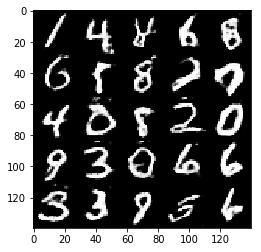

Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 2.1949
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 0.9660
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 1.5056... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.3850
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 1.9030


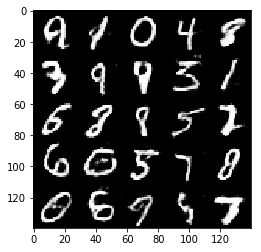

Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.8498
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.3446
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 3.3290
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 1.6241


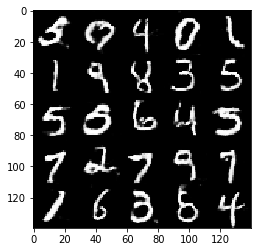

Epoch 2/2... Discriminator Loss: 2.3927... Generator Loss: 0.1504
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.5013
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 1.9093... Generator Loss: 3.3460


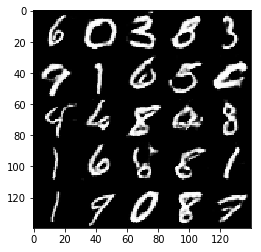

Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.8617
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.7290
Epoch 2/2... Discriminator Loss: 1.6189... Generator Loss: 3.2102
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 1.8569


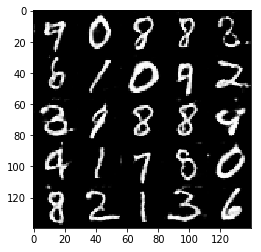

Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.8409
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.8824
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.7512
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.8600


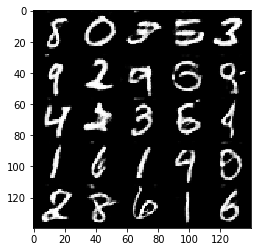

Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 1.4966
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.4580
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.9735
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 2.1751... Generator Loss: 0.1799
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.2612


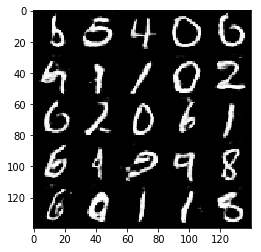

Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.6516... Generator Loss: 0.3226
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.4867
Epoch 2/2... Discriminator Loss: 1.7122... Generator Loss: 0.2930
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.5124


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 4.6732
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 7.1965
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 3.7073... Generator Loss: 0.0377
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.7057
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 2.5555
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.8017


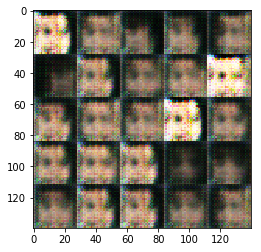

Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 2.0968... Generator Loss: 0.2227
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.9994... Generator Loss: 2.6562
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.5338


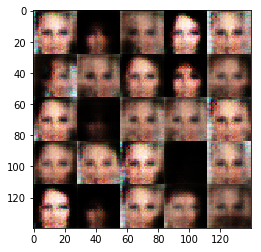

Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.9999
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 3.2656
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.3992


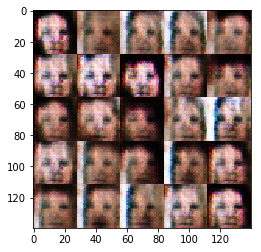

Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 5.0070
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.7275
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 2.3903
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 2.3185... Generator Loss: 5.4558
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.0546


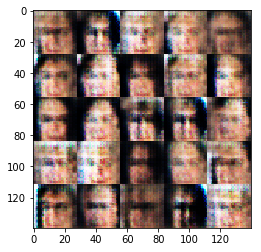

Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.2199
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 2.1087
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 3.0878
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 2.4391


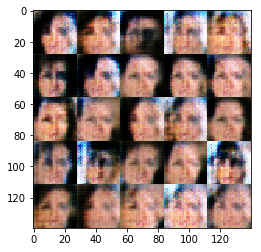

Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 2.6401
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 2.7180
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 3.0939
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 3.7636
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 4.2564
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 3.2486


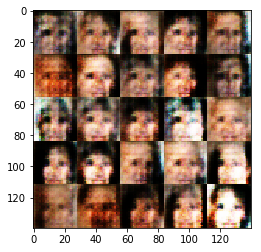

Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 4.5047
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 2.6785
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.8445
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.7667


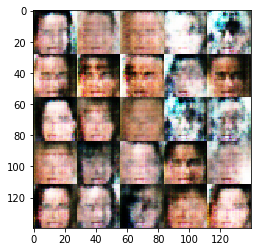

Epoch 1/1... Discriminator Loss: 2.0746... Generator Loss: 5.9397
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 3.1371... Generator Loss: 8.0151
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.6187
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 2.6005
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.5250
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.6290


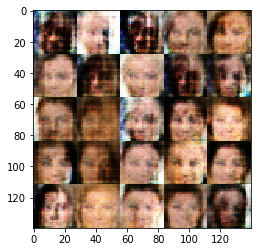

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 2.3381
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 4.2846
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.4676


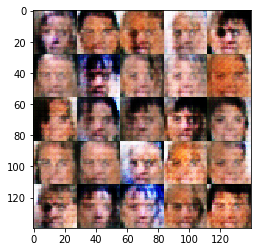

Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.8214
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.6553
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 2.1095
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 2.2385


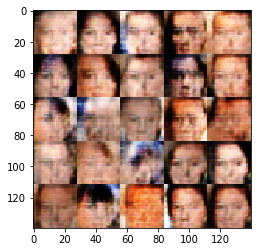

Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.2251
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 3.3352
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.9984


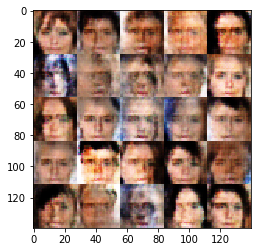

Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.8016
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 3.7418
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 2.8622
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.5765


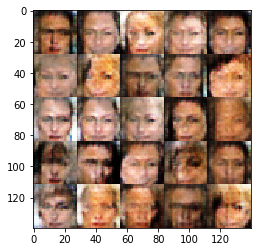

Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 2.7904
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 2.5101
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.3031


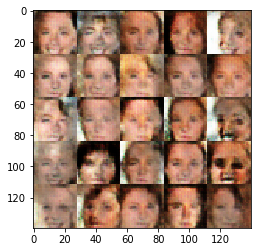

Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 4.1004
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 3.1916
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 2.3484
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 2.9865
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.2310


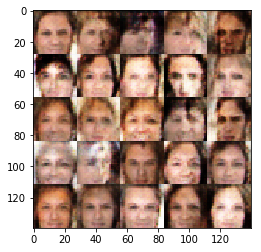

Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 1.9941
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.8400... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.3869


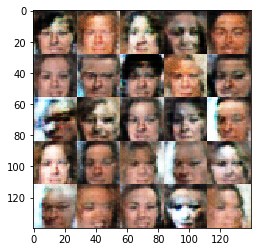

Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 2.1345
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 2.7424
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.2764
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 2.2451
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.6493


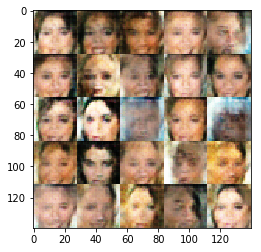

Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.2639
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 3.5321
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 5.4027
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.0065


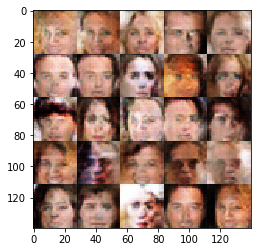

Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 3.6819
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 2.3242
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 2.7714
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 2.7536


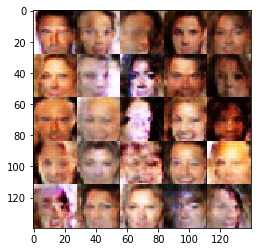

Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.1670


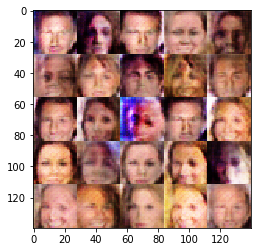

Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 1.4950
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 2.7062
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.4484
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 3.2851


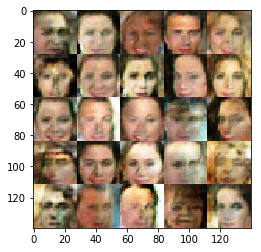

Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.1950
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 0.7832


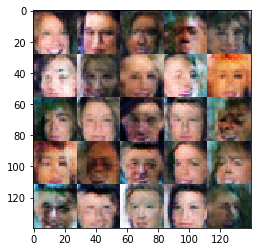

Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 3.7253
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.7184
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.6697


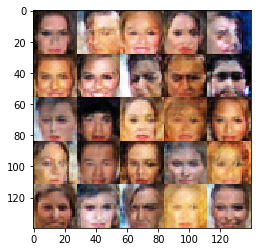

Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.8907... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.7286


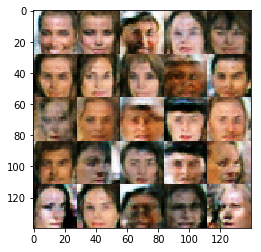

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 3.9116
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.4299
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.1039


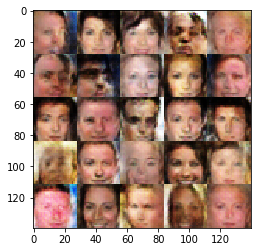

Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 2.1208
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.6286


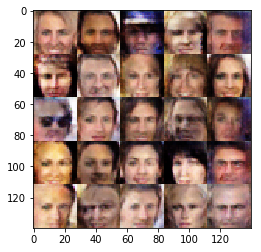

Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.8540
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 2.0168
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 2.5667
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 2.0180


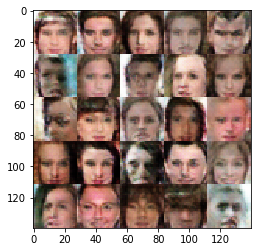

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.1581
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 2.1866


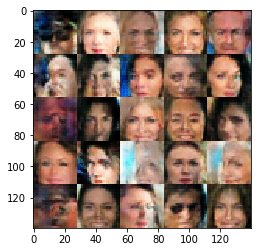

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 3.0261
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.3964


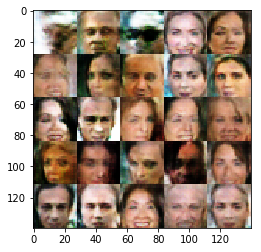

Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.6800
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.8676


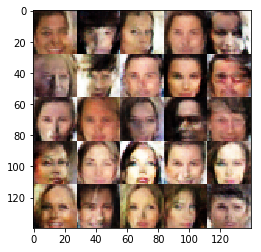

Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.9052
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.8630
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.5863
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.6528


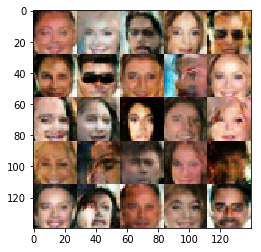

Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 2.3033
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.8481


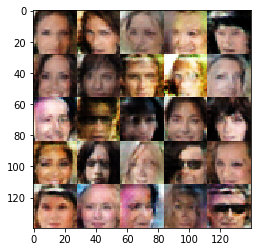

Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 2.7881
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.3999


In [14]:
batch_size = batch_size
z_dim = z_dim
learning_rate = learning_rate
beta1 = beta1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.